In [1]:
import scanpy as sc
import os
import math
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
import seaborn as sns

In [3]:
path = "./data/"

In [5]:
filelist=['DBL', 'ZSW', 'XD', 'LSQ', 'DZ',"DHBLZ"]

In [8]:
datalist= []
for line in filelist:
    print(line)
    tmp_data = sc.read_10x_mtx(path+line+"/",var_names='gene_symbols',cache=True)
    
    tmp_dict = {}
    tmp_data.var_names_make_unique()
    tmp_data.obs['sample'] = line
    datalist.append(tmp_data)

DBL
... reading from cache file cache/data-DBL-matrix.h5ad
ZSW
... reading from cache file cache/data-ZSW-matrix.h5ad
XD
... reading from cache file cache/data-XD-matrix.h5ad
LSQ
... reading from cache file cache/data-LSQ-matrix.h5ad
DZ
... reading from cache file cache/data-DZ-matrix.h5ad
DHBLZ
... writing an h5ad cache file to speedup reading next time


In [65]:
adata_all = datalist[0].concatenate(datalist[1:], batch_categories=filelist)

normalizing counts per cell
    finished (0:00:01)


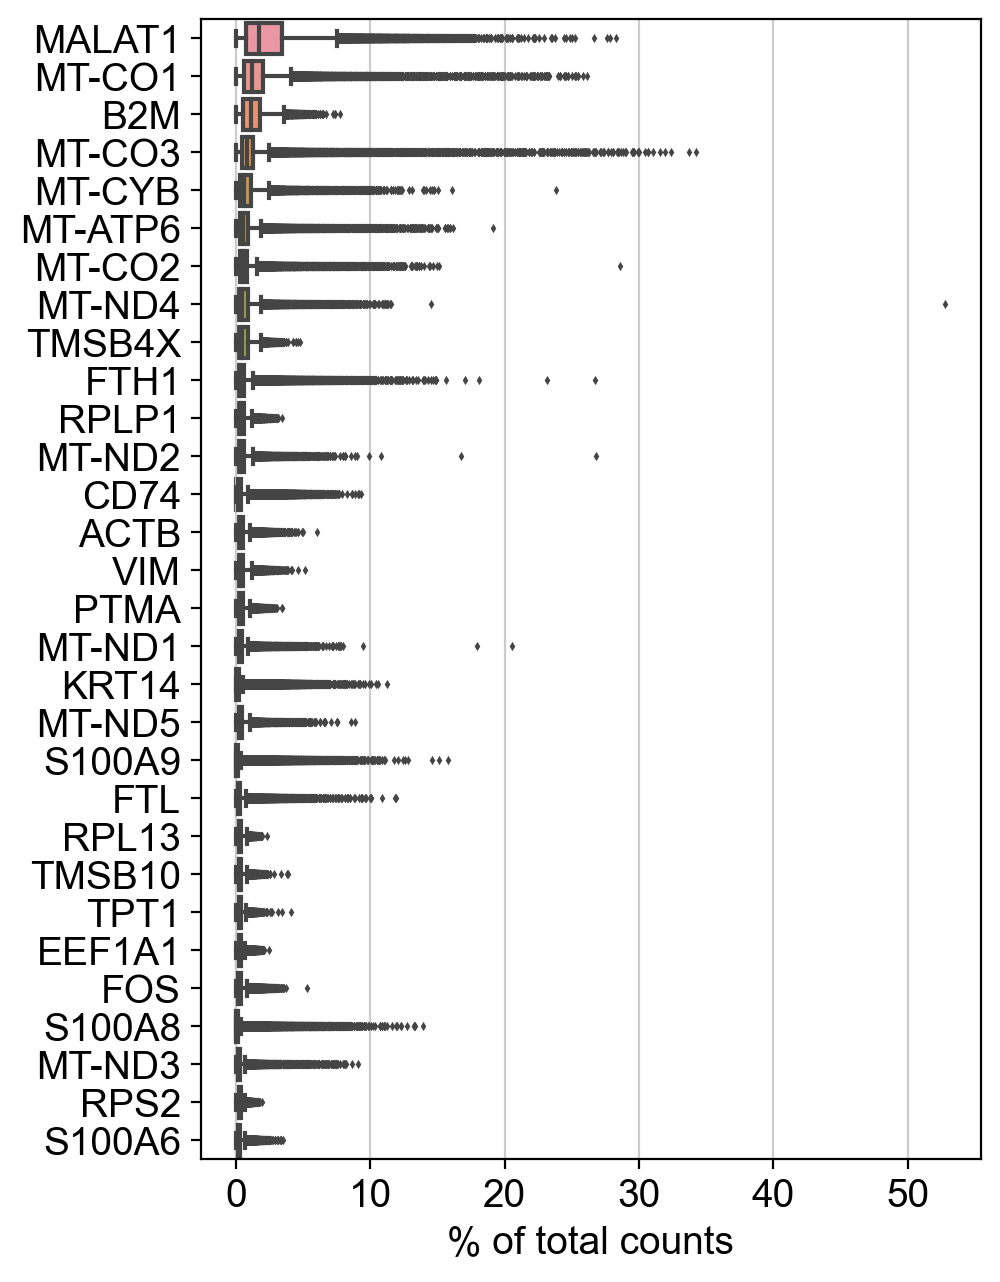

In [66]:
sc.pl.highest_expr_genes(adata_all, n_top=30)

In [67]:
sc.pp.filter_cells(adata_all, min_genes=800)   
sc.pp.filter_cells(adata_all, max_genes = 5000)
sc.pp.filter_cells(adata_all, min_counts= 2500)
sc.pp.filter_cells(adata_all, max_counts= 20000)
# sc.pp.filter_genes(adata_all, min_cells=10)     # 去除在100个细胞以下表达的基因

filtered out 24104 cells that have less than 800 genes expressed
filtered out 1106 cells that have more than 5000 genes expressed
filtered out 21570 cells that have less than 2500 counts
filtered out 1519 cells that have more than 20000 counts


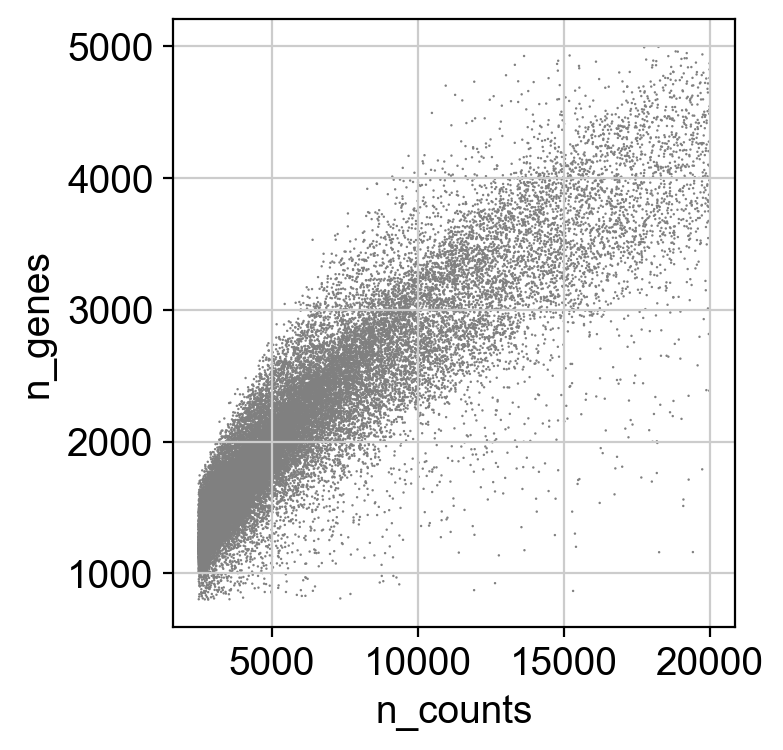

In [70]:
sc.pl.scatter(adata_all, x='n_counts', y='n_genes',projection="2d")

In [71]:
adata_all.obs['sample'].unique

<bound method Series.unique of AAACATCGAAACATCGACAAGCTA-DBL      DBL
AAACATCGAACTCACCATCATTCC-DBL      DBL
AAACATCGAAGGTACAAGCACCTC-DBL      DBL
AAACATCGAATCCGTCGATAGACA-DBL      DBL
AAACATCGACACAGAAGCTAACGA-DBL      DBL
                                ...  
TTTGTTGCAGTTGGTT-1-DHBLZ        DHBLZ
TTTGTTGCATAATCGC-1-DHBLZ        DHBLZ
TTTGTTGGTTGTCCCT-1-DHBLZ        DHBLZ
TTTGTTGTCGCACGAC-1-DHBLZ        DHBLZ
TTTGTTGTCGGACGTC-1-DHBLZ        DHBLZ
Name: sample, Length: 39320, dtype: category
Categories (6, object): ['DBL', 'DHBLZ', 'DZ', 'LSQ', 'XD', 'ZSW']>

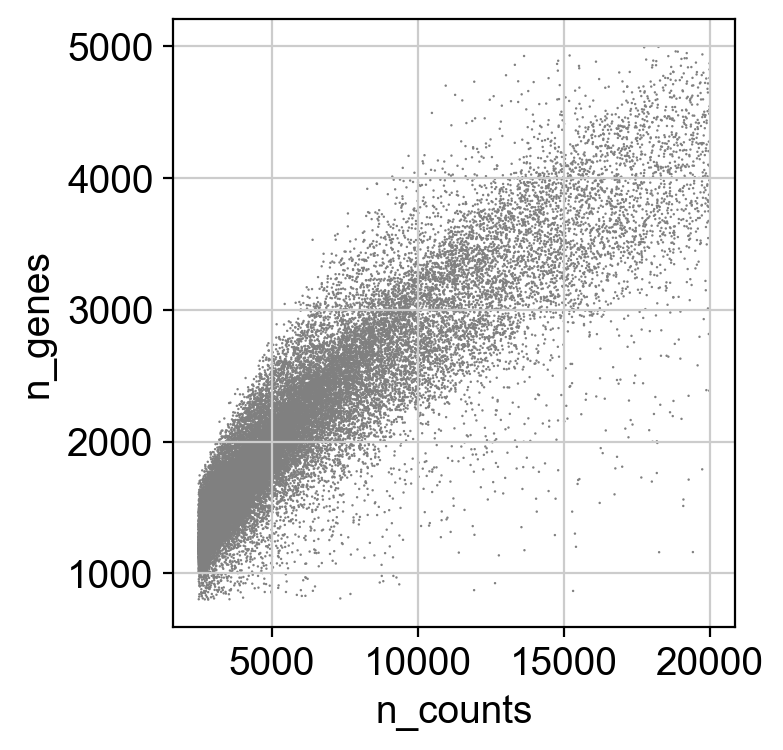

In [73]:
sc.pl.scatter(adata_all, x='n_counts', y='n_genes',projection="2d")

In [75]:
mito_genes = adata_all.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata_all.obs['percent_mito'] = np.sum(
    adata_all[:, mito_genes].X, axis=1).A1 / np.sum(adata_all.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata_all.obs['n_counts'] = adata_all.X.sum(axis=1).A1

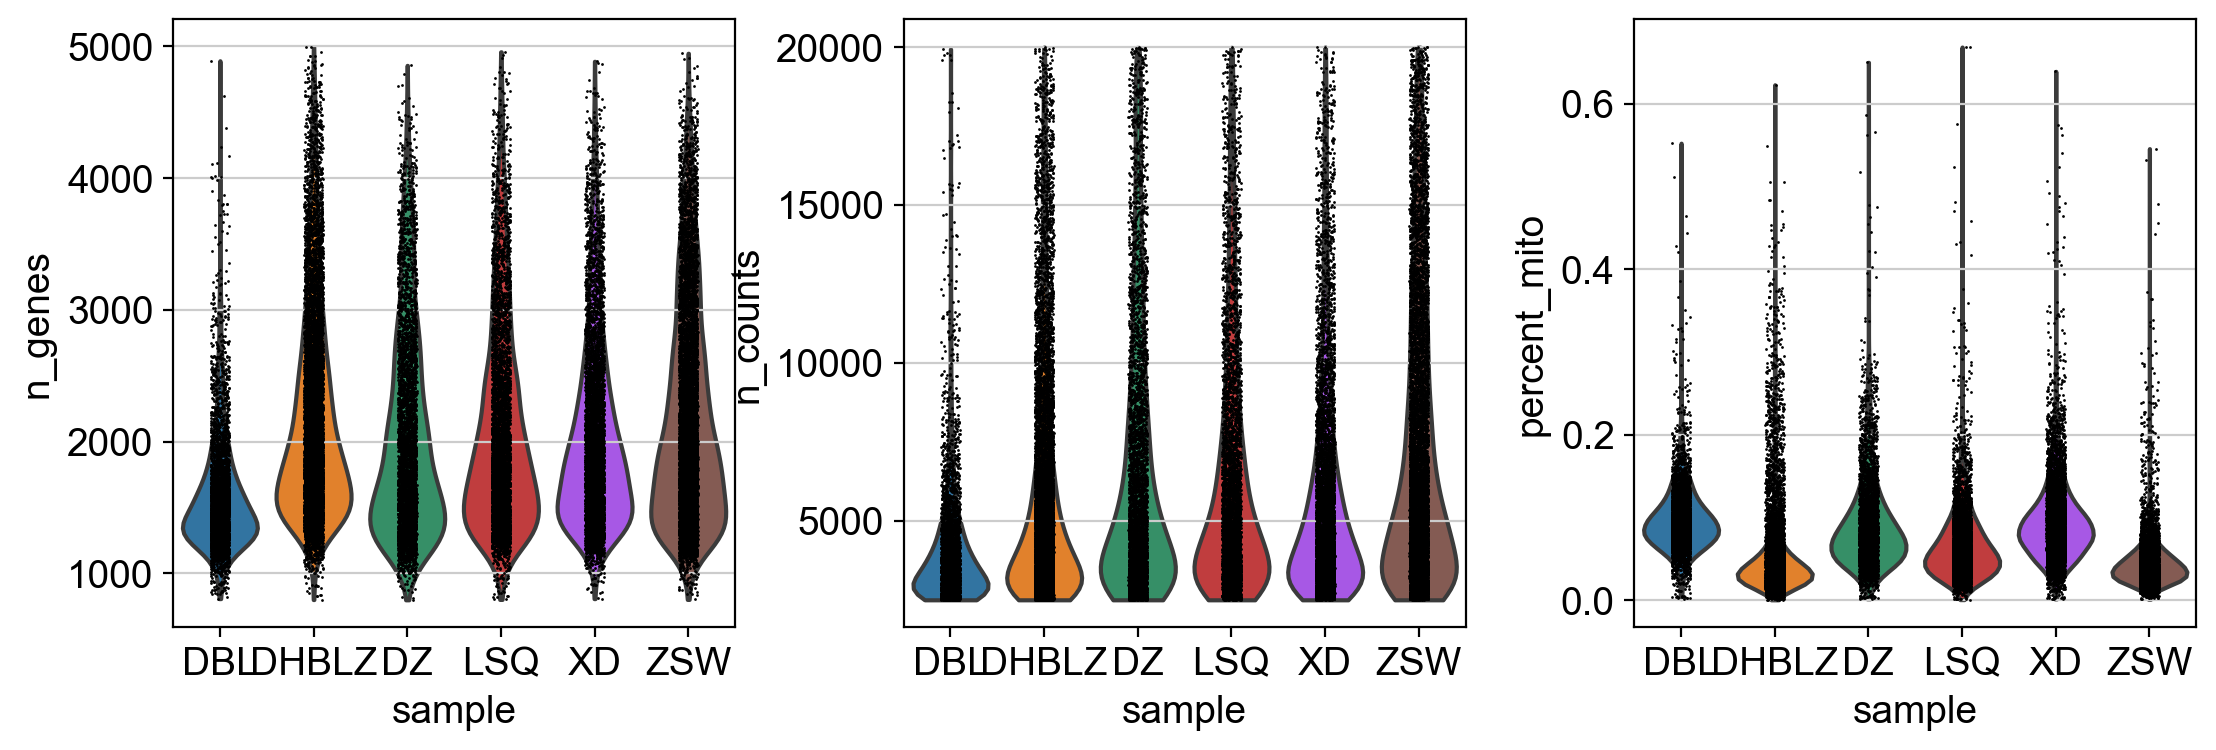

In [76]:
sc.pl.violin(adata_all, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.1, multi_panel=True,groupby="sample")

In [77]:
adata_all[adata_all.obs['percent_mito'] < 0.20, :]

View of AnnData object with n_obs × n_vars = 38347 × 35778
    obs: 'sample', 'batch', 'n_genes', 'n_counts', 'percent_mito'
    var: 'feature_types', 'gene_ids-DBL', 'gene_ids-DHBLZ', 'gene_ids-DZ', 'gene_ids-LSQ', 'gene_ids-XD', 'gene_ids-ZSW'
    uns: 'sample_colors'

In [78]:
adata_all = adata_all[adata_all.obs['percent_mito'] < 0.20, :]

In [80]:
malat1 = adata_all.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata_all.var_names.str.startswith('MT-')
hb_genes = adata_all.var_names.str.contains('^HB[^(P)]')
ht_genes = adata_all.var_names.str.startswith('RPL','RPS')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
remove = np.add(remove, ht_genes)
keep = np.invert(remove)

# adata = adata[:,keep]

print(adata_all.n_obs, adata_all.n_vars)

38347 35778


In [84]:
g = """ZSW CHC
LSQ CHC
DHBLZ CHC
DBL HC
DZ  HC
XD HC""".split("\n")

In [85]:
adata_all.obs['group'] = adata_all.obs['batch'].astype(str)
for line in g:
    linelist = line.split()
    mask = adata_all.obs['batch'] == linelist[0]
    adata_all.obs.loc[mask,'group'] = linelist[1]

In [86]:
adata_all.obs

,sample,batch,n_genes,n_counts,percent_mito,group
AAACATCGAAACATCGACAAGCTA-DBL,DBL,DBL,1350,3048.0,0.142388,HC
AAACATCGAACTCACCATCATTCC-DBL,DBL,DBL,1423,2870.0,0.066202,HC
AAACATCGAAGGTACAAGCACCTC-DBL,DBL,DBL,1559,3481.0,0.151968,HC
AAACATCGAATCCGTCGATAGACA-DBL,DBL,DBL,1204,2766.0,0.137744,HC
AAACATCGACACAGAAGCTAACGA-DBL,DBL,DBL,1210,2541.0,0.117277,HC
...,...,...,...,...,...,...
TTTGTTGCAGGTGAGT-1-DHBLZ,DHBLZ,DHBLZ,1404,4677.0,0.056446,CHC
TTTGTTGCATAATCGC-1-DHBLZ,DHBLZ,DHBLZ,2173,3968.0,0.025958,CHC
TTTGTTGGTTGTCCCT-1-DHBLZ,DHBLZ,DHBLZ,2890,8627.0,0.017271,CHC
TTTGTTGTCGCACGAC-1-DHBLZ,DHBLZ,DHBLZ,2813,6093.0,0.023634,CHC


In [87]:
import scrublet as scr

# split per batch into new objects.
batches = adata_all.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    tmp = adata_all[adata_all.obs['sample'] == batch,]
    print(batch, ":", tmp.shape[0], " cells")
    scrub = scr.Scrublet(tmp.X)
    out = scrub.scrub_doublets(verbose=False, n_prin_comps = 20)
    alldata[batch] = pd.DataFrame({'doublet_score':out[0],'predicted_doublets':out[1]},index = tmp.obs.index)
    print(alldata[batch].predicted_doublets.sum(), " predicted_doublets")

DBL : 4195  cells
353  predicted_doublets
DHBLZ : 10215  cells
255  predicted_doublets
DZ : 4281  cells
69  predicted_doublets
LSQ : 4730  cells
97  predicted_doublets
XD : 6538  cells
183  predicted_doublets
ZSW : 8388  cells
170  predicted_doublets


In [88]:
# # add predictions to the adata object.
scrub_pred = pd.concat(alldata.values())
adata_all.obs['doublet_scores'] = scrub_pred['doublet_score'] 
adata_all.obs['predicted_doublets'] = scrub_pred['predicted_doublets'] 

sum(adata_all.obs['predicted_doublets'])

1127

In [89]:
adata_all = adata_all[adata_all.obs['predicted_doublets'] == False]

In [90]:
adata_all

View of AnnData object with n_obs × n_vars = 37220 × 35778
    obs: 'sample', 'batch', 'n_genes', 'n_counts', 'percent_mito', 'group', 'doublet_scores', 'predicted_doublets'
    var: 'feature_types', 'gene_ids-DBL', 'gene_ids-DHBLZ', 'gene_ids-DZ', 'gene_ids-LSQ', 'gene_ids-XD', 'gene_ids-ZSW'
    uns: 'sample_colors'

In [105]:
adata_all.var['gene_ids'] = adata_all.var['gene_ids-DBL']

In [106]:
adata_all.raw = adata_all

In [107]:
sc.pp.normalize_per_cell(adata_all, counts_per_cell_after=1e4)
sc.pp.log1p(adata_all)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [108]:
sc.pp.highly_variable_genes(adata_all,n_top_genes=2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [111]:
adata_all.var.highly_variable = adata_all.var.highly_variable & [ not x.startswith(('RPL', 'RPS', 'MT-' )) for x in adata_all.var.index ]
sum(adata_all.var.highly_variable)

1999

In [112]:
sc.pp.scale(adata_all,)
sc.tl.pca( adata_all, svd_solver='arpack', use_highly_variable = True,n_comps=20)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=20
    finished (0:00:05)


In [114]:
if True:
    sc.external.pp.harmony_integrate(adata_all, 'batch',  
                                     basis = 'X_pca',  
                                     adjusted_basis= 'X_pca_harmony', 
                                     )

2024-06-15 10:42:14,628 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-15 10:42:19,952 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-15 10:42:20,155 - harmonypy - INFO - Iteration 1 of 10
2024-06-15 10:42:33,945 - harmonypy - INFO - Iteration 2 of 10
2024-06-15 10:42:46,909 - harmonypy - INFO - Iteration 3 of 10
2024-06-15 10:43:00,311 - harmonypy - INFO - Iteration 4 of 10
2024-06-15 10:43:13,865 - harmonypy - INFO - Iteration 5 of 10
2024-06-15 10:43:27,590 - harmonypy - INFO - Iteration 6 of 10
2024-06-15 10:43:41,525 - harmonypy - INFO - Iteration 7 of 10
2024-06-15 10:43:55,525 - harmonypy - INFO - Converged after 7 iterations


In [115]:
sc.pp.neighbors(adata_all, use_rep= 'X_pca_harmony')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [116]:
sc.tl.umap(adata_all)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)


In [117]:
sc.tl.leiden(adata_all,resolution=1,key_added="cluster_1")

running Leiden clustering
    finished: found 28 clusters and added
    'cluster_1', the cluster labels (adata.obs, categorical) (0:00:22)


In [118]:
sc.tl.leiden(adata_all,resolution=2,key_added="cluster_2")

running Leiden clustering
    finished: found 44 clusters and added
    'cluster_2', the cluster labels (adata.obs, categorical) (0:00:25)


In [121]:
maker_gene = {
 "CAFs":[ "COL1A1", "COL3A1","DCN"],
"Endothilial":[ "CLDN5","CDH5","VWF",'PECAM1'],
'pDC':["LILRA4","IL3RA"],
    'mDC':['CD1C'],
"Mast cells":["MS4A2","TPSAB1"],
#     LYZ、CD68、MS4A6A、CD1E、IL3RA和LAMP3
"Epithelial": ["EPCAM","KRT5","KRT18"],
#     EPCAM、KRT19、KRT18、KRT5和KRT15
"Macrophages":["CD68", "CD163"] ,
'Myeloid cells':['CD14','LYZ',],
#     LYZ、CD68、MS4A6A、CD1E、IL3RA和LAMP3 
"B_cells":["CD79A","CD79B"],
"Plasma cell":[ "MZB1","JCHAIN"],
"T cells":["CD3D","CD3E","TRAC","CD40LG","CD8A"],
"NK": ["KLRD1","KLRB1","NKG7"],
    "SMCs":['RGS5',"TAGLN"],
    "myocyte":["TNNC1"],
# "T cells CD8":["CD3D","CD3G",'CD8A'],
# "NK cells": ["KLRF1","KLRD1","PRF1","NKG7","GNLY"],
    "Neutrophils":['CSF3R','CXCR2','FCGR3B'],
    "ohters":["MKI67","HBB" , "NR2F2" , "PLVAP","KIT","ACTA2","TAGLN","RGS5","MYH11","S100B","CRYAB","TOP2A"]
   
}

    using 'X_pca' with n_pcs = 20
Storing dendrogram info using `.uns['dendrogram_cluster_1']`
categories: 0, 1, 2, etc.
var_group_labels: CAFs, Endothilial, pDC, etc.


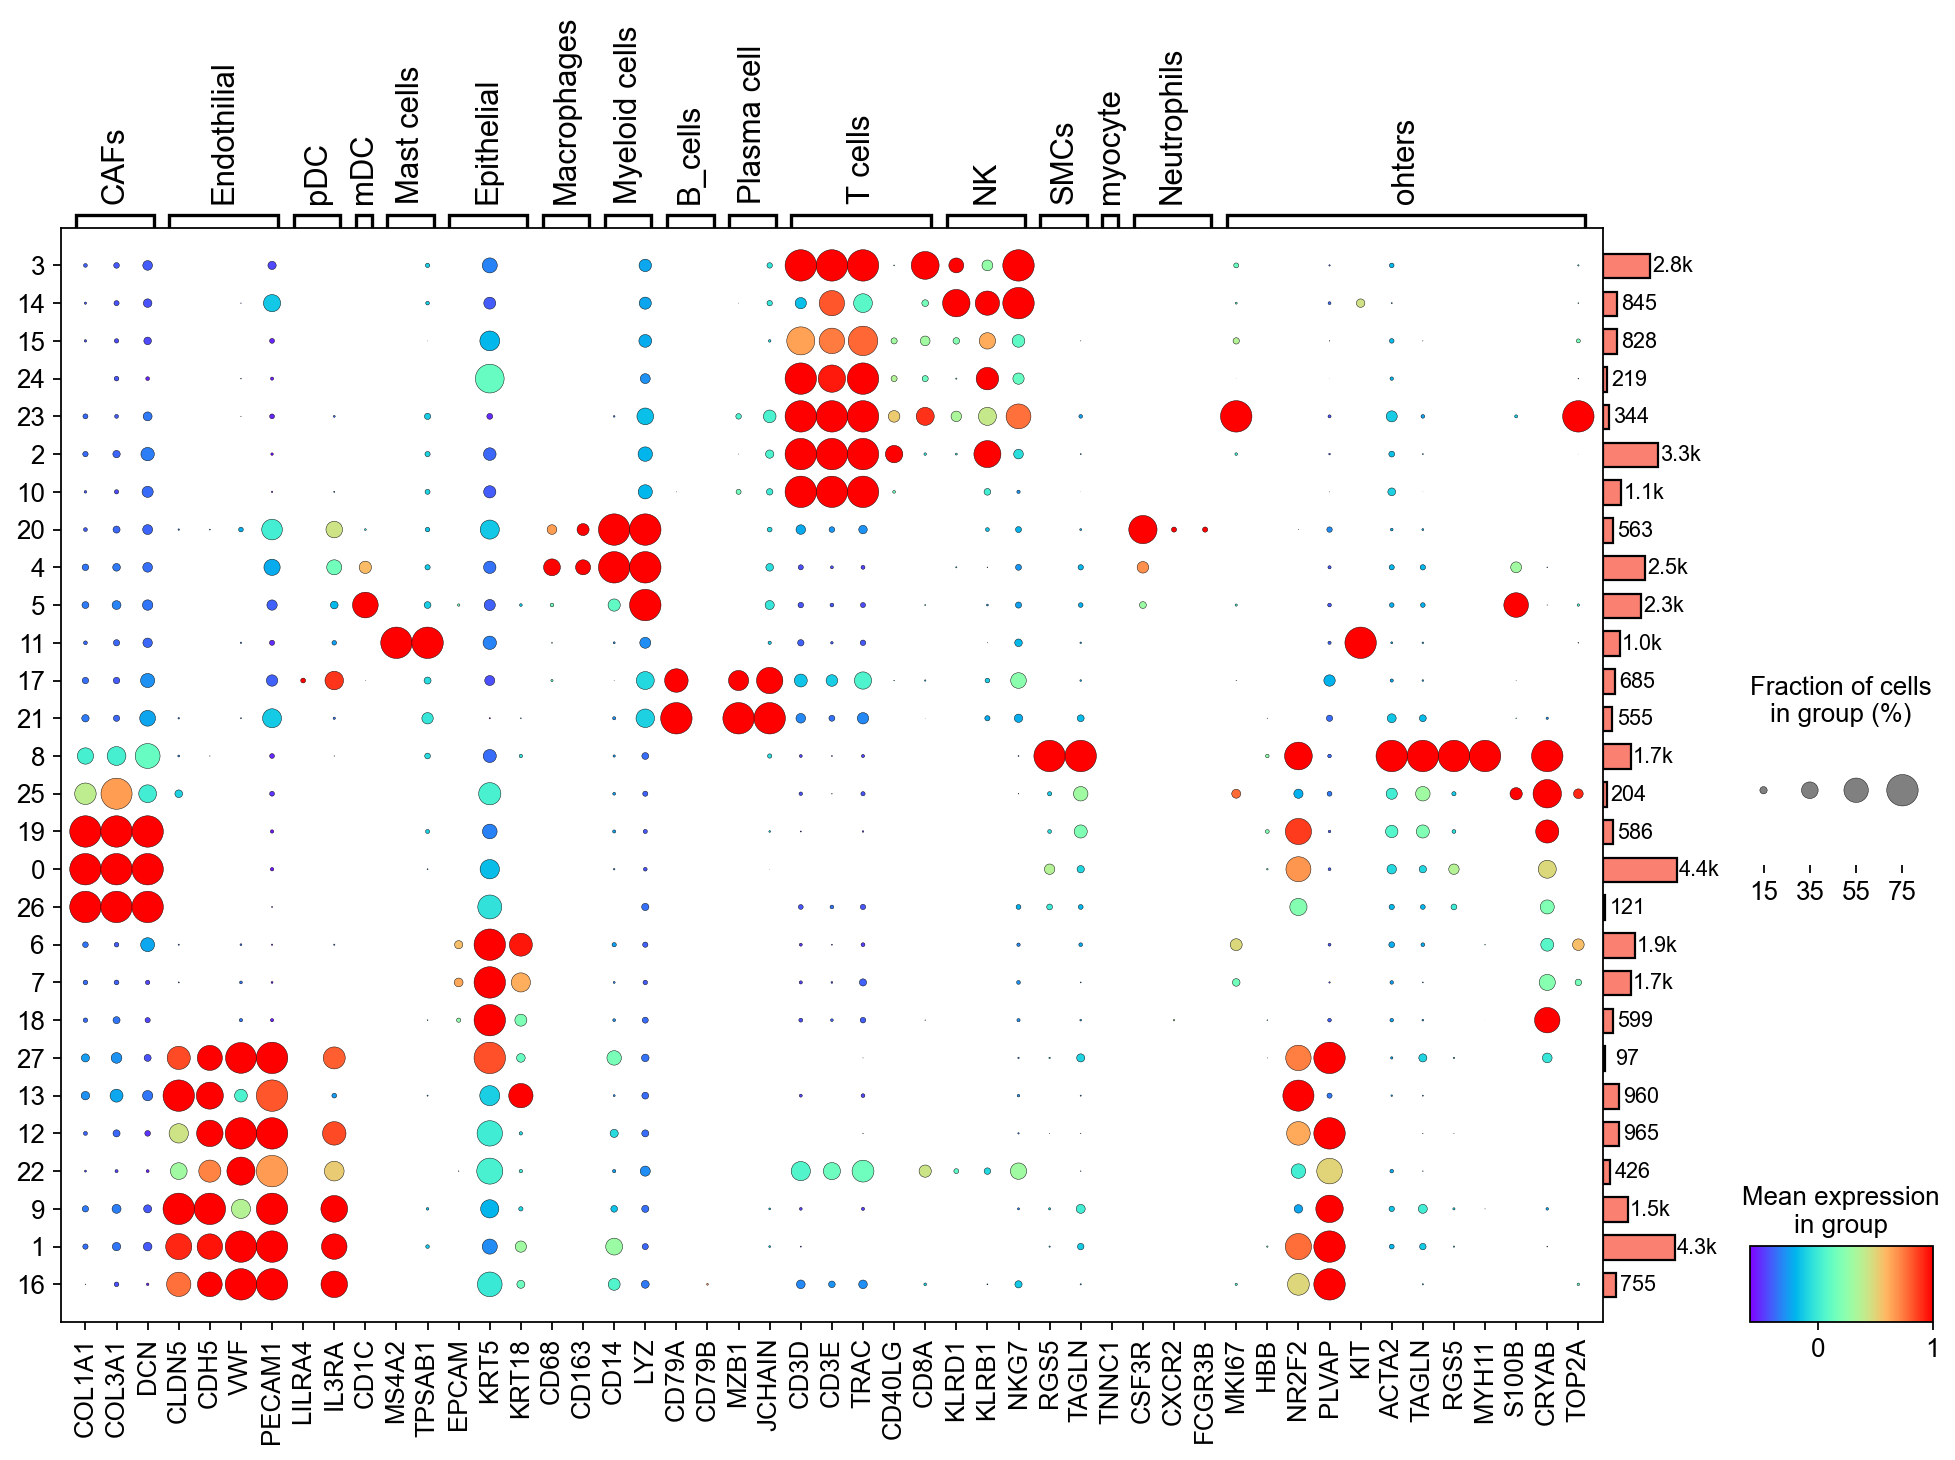

In [125]:
sc.settings.set_figure_params(dpi=80, facecolor='white', dpi_save =100)
myplot = sc.pl.dotplot(adata_all, maker_gene, groupby='cluster_1', var_group_rotation=90,
                       color_map= 'rainbow', mean_only_expressed=False,return_fig=True,
                       dot_min=0.05,use_raw=False,
                       dot_max=0.75,
                       vmax=1,
                       dendrogram=True,
                      figsize=(15,9),)
myplot.add_totals().show()

In [135]:
celltype_Major = {
 "Fibroblasts":[0,19,26],
"Endothilial_PLVAP+VFM+":[12,1,16],
    "Endothilial_PLVAP+VFM-":[9,],
    "Endothilial_PLVAP-":[13],
"Mast cells":[11],
"Epithelial cells": [6,7,18],
'Myeloid cells':[20,4,5],
"B/Plasma cells":[17,21],
"T/NK cells":[3,14,15,24,23,2,10],
    "SMCs":[8],
    'Neutrophils':[],
    'UN':[25,27,22]
   
}

In [136]:

adata_all.obs['celltype_Major'] = adata_all.obs['cluster_1'].astype(str)
for key in celltype_Major:
    mask = adata_all.obs['cluster_1'].isin(map(str,celltype_Major[key]))
    adata_all.obs.loc[mask,"celltype_Major"] = key


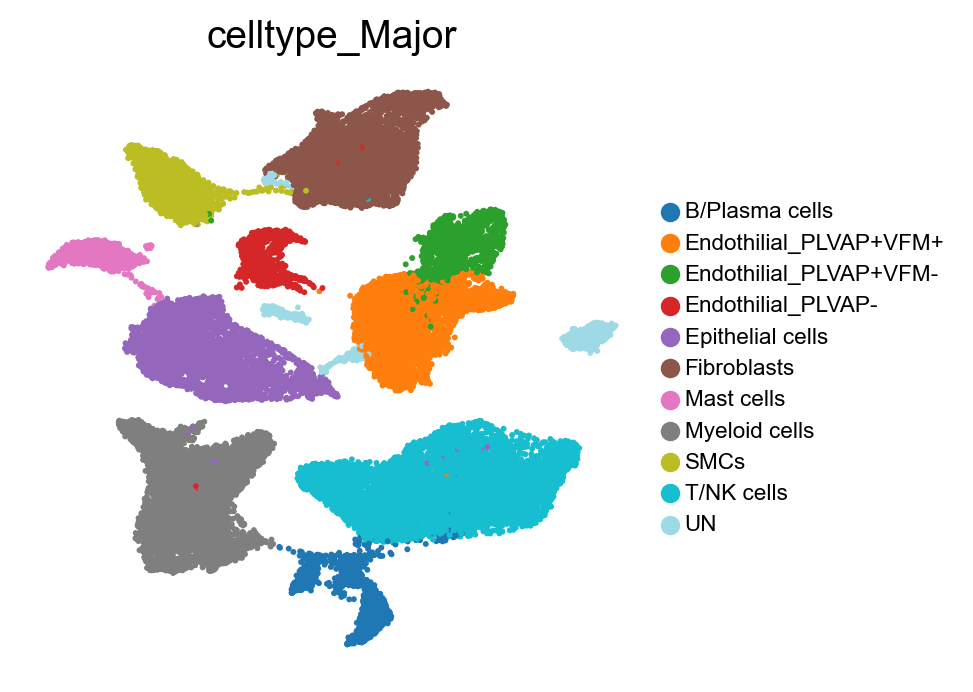

In [137]:
sc.pl.umap(adata_all,  ncols = 3,  color= ['celltype_Major',],
               palette= 'tab20',legend_fontsize="xx-small", 
           frameon=False, s=18, vmax=1,vmin=-1,
           # legend_loc='on data',
           title= ('celltype_Major'))

In [142]:
temp = adata_all[adata_all.obs.celltype_Major != 'UN']

In [143]:
temp.obs.groupby("sample").count()

,batch,n_genes,n_counts,percent_mito,group,doublet_scores,predicted_doublets,cluster_1,cluster_2,celltype_Major
sample,,,,,,,,,,
DBL,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816
DHBLZ,9507,9507,9507,9507,9507,9507,9507,9507,9507,9507
DZ,4122,4122,4122,4122,4122,4122,4122,4122,4122,4122
LSQ,4612,4612,4612,4612,4612,4612,4612,4612,4612,4612
XD,6241,6241,6241,6241,6241,6241,6241,6241,6241,6241
ZSW,8195,8195,8195,8195,8195,8195,8195,8195,8195,8195


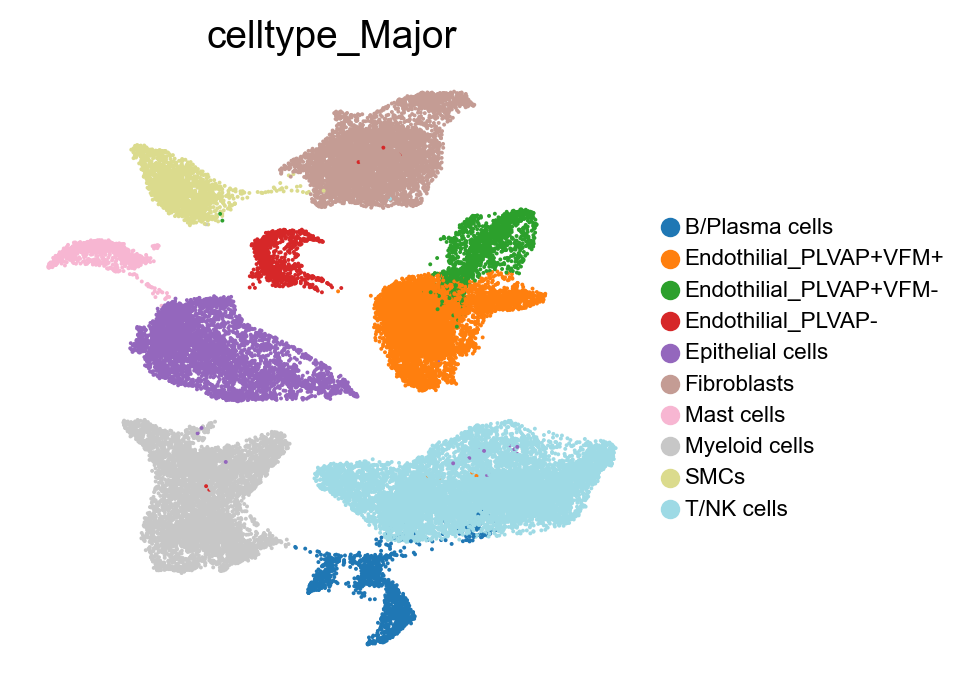

In [144]:
sc.pl.umap(temp,  ncols = 3,  color= ['celltype_Major',],
               palette= 'tab20',legend_fontsize="xx-small", 
           frameon=False, s=8, vmax=1,vmin=-1,
           title= ('celltype_Major'))

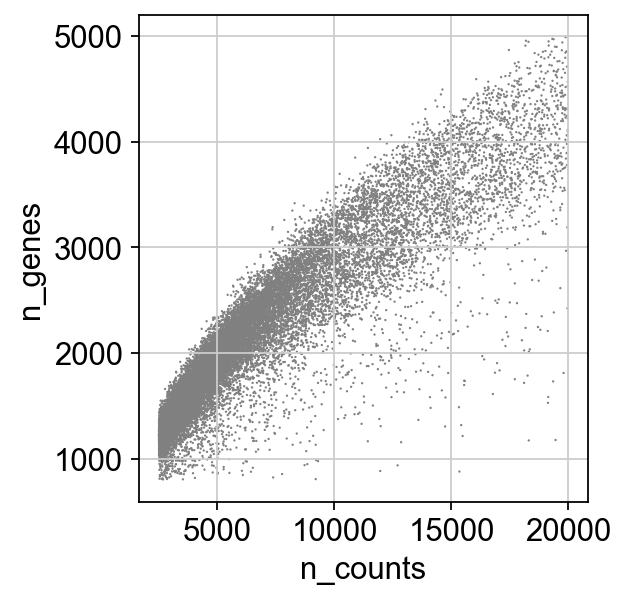

In [173]:
sc.pl.scatter(temp, x='n_counts', y='n_genes',projection="2d")

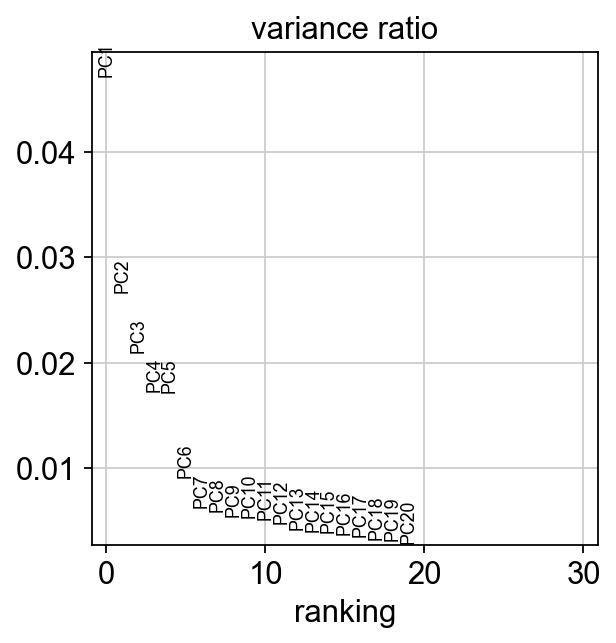

In [119]:
sc.pl.pca_variance_ratio(temp,show=False)

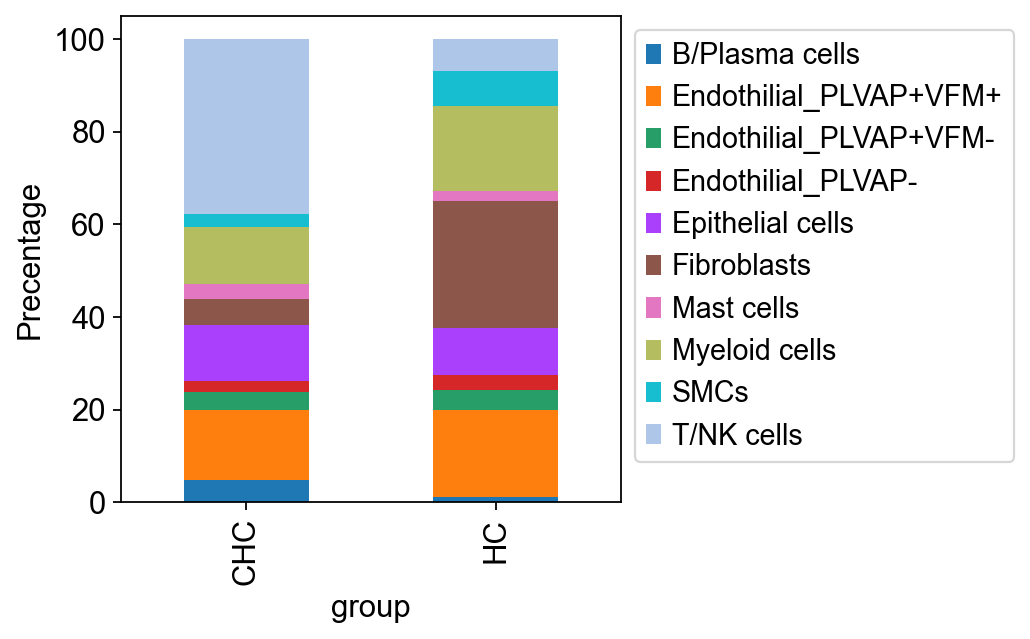

In [145]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
list_conditions= ('Ctrl','CHC')
condition=('group')
mask = temp.obs['group'].isin(list_conditions)
# temp1 = temp[mask]
temp1 = temp.obs.groupby(['group','celltype_Major']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()
ax = temp1.plot(kind='bar',stacked=True,grid=("None"), legend= bool,mark_right=bool)
ax.legend(bbox_to_anchor=(1,1))
#b.get_legend().remove()
ax.set_ylabel('Precentage')
ax.grid(None)

In [146]:
temp.write_h5ad("clean0615.h5ad")

In [175]:
adata_all.write_h5ad("raw1210.h5ad")